In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # 指定使用 GPU 3
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
# import torch

In [2]:
import keras_nlp
import keras
import keras.backend as K
import tensorflow as tf

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import polars as pl
TF_ENABLE_ONEDNN_OPTS=0
#cmap = mpl.cm.get_cmap('coolwarm')


2024-06-02 15:21:42.443951: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-02 15:21:42.483755: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 15:21:42.483790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 15:21:42.484947: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-02 15:21:42.491450: I tensorflow/core/platform/cpu_feature_guar

In [3]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)

TensorFlow: 2.15.0
Keras: 3.2.1
KerasNLP: 0.9.3


## deberta fine-tune

In [4]:
class CFG:
    seed = 42  # Random seed
    preset = "deberta_v3_extra_small_en" # Name of pretrained models
    sequence_length = 512  # Input sequence length
    epochs = 3 # Training epochs
    batch_size = 32  # Batch size
    scheduler = 'cosine'  # Learning rate scheduler

In [5]:
keras.utils.set_random_seed(CFG.seed) ##每次的随机值相同，方便复现
#keras.mixed_precision.set_global_policy("mixed_float16")

## 读取数据

In [6]:
columns = [  
    (
        pl.col("full_text").str.split(by="\n\n").alias("paragraph")
    ),
]
PATH = "kaggle/input/learning-agency-lab-automated-essay-scoring-2/"

# Load training and testing sets, while using \ n \ n character segmentation to list and renaming to paragraph for full_text data
train = pl.read_csv(PATH + "train.csv").with_columns(columns) 
test = pl.read_csv(PATH + "test.csv").with_columns(columns)

In [7]:
from sklearn.model_selection import train_test_split  # Import package

train, valid = train_test_split(train, test_size=0.2, stratify= train['score'])

In [8]:
def to_ordinal(y, num_classes=None, dtype="float32"):
    """
    评分值编码
    """
    y = np.array(y, dtype="int")
    input_shape = y.shape

    # Shrink the last dimension if the shape is (..., 1).
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])

    y = y.reshape(-1)
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    range_values = np.arange(num_classes - 1)
    range_values = np.tile(np.expand_dims(range_values, 0), [n, 1])
    ordinal = np.zeros((n, num_classes - 1), dtype=dtype)
    ordinal[range_values < np.expand_dims(y, -1)] = 1
    output_shape = input_shape + (num_classes - 1,)
    ordinal = np.reshape(ordinal, output_shape)
    return ordinal

In [9]:
a = to_ordinal(train['score']).tolist()
a = pl.Series('lables', a)
b = to_ordinal(valid['score']).tolist()
b = pl.Series('lables', b)

train = train.with_columns(a)
valid = valid.with_columns(b)

#### 1. 加载预处理模型

In [10]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset, # Name of the model
    sequence_length=CFG.sequence_length, # Max sequence length, will be padded if shorter
)

def preprocess_fn(text, label=None):
    text = preprocessor(text)  # Preprocess text
    return (text, label) if label is not None else text  # Return processed text and label if available

2024-06-02 15:21:49.241676: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22272 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:57:00.0, compute capability: 8.6


### 添加数据

In [11]:
def build_dataset(texts, labels=None, batch_size=32,
                  cache=True, drop_remainder=True,
                  shuffle=1024):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (texts,) if labels is None else (texts, labels)  # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)  # 针对数据集做预处理
    opt = tf.data.Options()  # Create dataset options
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)  # Batch dataset
    ds = ds.prefetch(AUTO)  # Prefetch next batch
    return ds

In [12]:
# Train Data
train_texts = train['full_text']  # Extract training texts
train_labels = np.array(train['lables']) # Extract training labels

train_texts = train_texts.to_list()
train_labels = train_labels.tolist()

# Valid Data
valid_texts = valid['full_text']  # Extract validation texts
valid_texts = valid_texts.to_list()
valid_labels =  np.array(valid['lables']) # Extract validation labels
valid_labels =valid_labels .tolist()

In [13]:
# Build training dataset
train_ds = build_dataset(
    train_texts, train_labels, batch_size=CFG.batch_size, shuffle=True
)

# Build validation dataset
valid_ds = build_dataset(
    valid_texts, valid_labels, batch_size=CFG.batch_size, shuffle=False
)

### 加载模型，并且会返回一个模型的最佳微调，

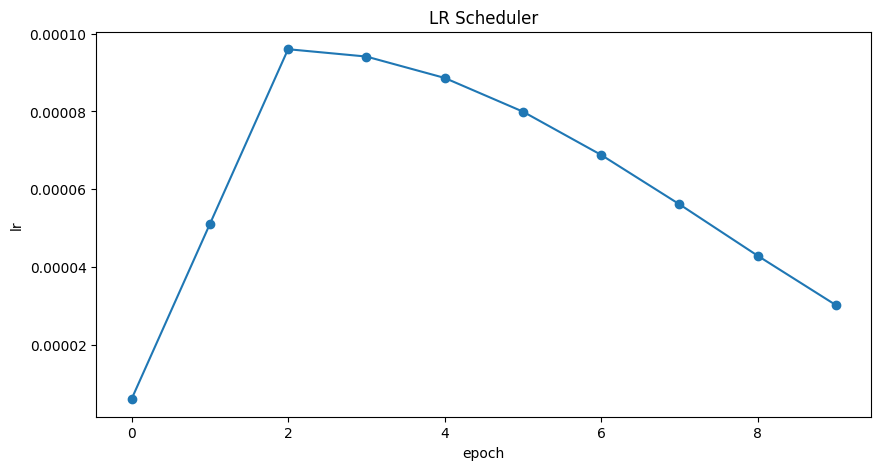

In [14]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 0.6e-5, 0.3e-5 * batch_size, 0.3e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 2, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

lr_cb = get_lr_callback(CFG.batch_size, plot=True)

ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.weights.h5",
    monitor="val_weighted_kappa",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
)

In [15]:
class WeightedKappa(keras.metrics.Metric):
    
    def __init__(self, num_classes=6, epsilon=1e-6):
        super().__init__(name="weighted_kappa")
        self.num_classes = num_classes
        self.epsilon = epsilon

        label_vec = keras.ops.arange(num_classes, dtype=keras.backend.floatx())
        self.row_label_vec = keras.ops.reshape(label_vec, [1, num_classes])
        self.col_label_vec = keras.ops.reshape(label_vec, [num_classes, 1])
        col_mat = keras.ops.tile(self.col_label_vec, [1, num_classes])
        row_mat = keras.ops.tile(self.row_label_vec, [num_classes, 1])
        self.weight_mat = (col_mat - row_mat) ** 2

        self.numerator = self.add_weight(name="numerator", initializer="zeros")
        self.denominator = self.add_weight(name="denominator", initializer="zeros")
        self.o_sum = self.add_weight(name="o_sum", initializer="zeros")
        self.e_sum = self.add_weight(name="e_sum", initializer="zeros")

    def update_state(self, y_true, y_pred, **args):
        # revert ordinal regression labels to classification labels

        y_true = keras.ops.one_hot(keras.ops.sum(keras.ops.cast(y_true, dtype="int8"), axis=-1) - 1, 6)
        y_pred = keras.ops.one_hot(
            keras.ops.sum(keras.ops.cast(y_pred > 0.5, dtype="int8"), axis=-1) - 1, 6
        )
        # weighted kappa calculation
        y_true = keras.ops.cast(y_true, dtype=self.col_label_vec.dtype)
        y_pred = keras.ops.cast(y_pred, dtype=self.weight_mat.dtype)
        batch_size = keras.ops.shape(y_true)[0]

        cat_labels = keras.ops.matmul(y_true, self.col_label_vec)
        cat_label_mat = keras.ops.tile(cat_labels, [1, self.num_classes])
        row_label_mat = keras.ops.tile(self.row_label_vec, [batch_size, 1])

        weight = (cat_label_mat - row_label_mat) ** 2

        self.numerator.assign_add(keras.ops.sum(weight * y_pred))
        label_dist = keras.ops.sum(y_true, axis=0, keepdims=True)
        pred_dist = keras.ops.sum(y_pred, axis=0, keepdims=True)
        w_pred_dist = keras.ops.matmul(
            self.weight_mat, keras.ops.transpose(pred_dist, [1, 0])
        )
        self.denominator.assign_add(
            keras.ops.sum(keras.ops.matmul(label_dist, w_pred_dist))
        )

        self.o_sum.assign_add(keras.ops.sum(y_pred))
        self.e_sum.assign_add(
            keras.ops.sum(
                keras.ops.matmul(keras.ops.transpose(label_dist, [1, 0]), pred_dist)
            )
        )

    def result(self):
        return 1.0 - (
            keras.ops.divide_no_nan(self.numerator, self.denominator)
            * keras.ops.divide_no_nan(self.e_sum, self.o_sum)
        )

    def reset_state(self):
        self.numerator.assign(0)
        self.denominator.assign(0)
        self.o_sum.assign(0)
        self.e_sum.assign(0)

In [16]:
# Create a DebertaV3Classifier model
classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
    CFG.preset, preprocessor=None, num_classes=6
)
inputs = classifier.input
logits = classifier(inputs)

# Compute final output
outputs = keras.layers.Activation("sigmoid")(logits)

# Build Model
model = keras.Model(inputs, outputs)

# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer = keras.optimizers.Adam(5e-6),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = [WeightedKappa()],
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deberta_v3_classif… │ (None, 6)         │ 70,832,262 │ padding_mask[0][… │
│ (DebertaV3Classifi… │                   │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 6)         │          0 │ deberta_v3_class… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,832,262 (270.20 MB)

 Trainable params: 70,832,262 (270.20 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Start training the model
history = model.fit(
    train_ds,
    epochs=CFG.epochs,
    validation_data=valid_ds,
    callbacks=[lr_cb, ckpt_cb]
)

Epoch 1/3


2024-06-02 15:22:20.936786: I external/local_xla/xla/service/service.cc:168] XLA service 0x340573b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-02 15:22:20.936853: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-06-02 15:22:22.875366: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-02 15:22:32.764431: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8905
2024-06-02 15:23:08.100630: W external/local_xla/xla/service/gpu/buffer_comparator.cc:1054] INTERNAL: ptxas exited with non-zero error code 65280, output: ptxas /tmp/tempfile-dell-R8428-G12-6032ac42-1696146-619e3169f2fda, line 10; fatal   : Unsupported .version 7.8; current version is '7.5'
ptxas fatal   : Ptx assembly aborted due to errors

Relying on d

432/432 ━━━━━━━━━━━━━━━━━━━━ 242s 306ms/step - loss: 0.4628 - weighted_kappa: 0.1396 - val_loss: 0.2102 - val_weighted_kappa: 0.6509 - learning_rate: 6.0000e-06
Epoch 2/3
432/432 ━━━━━━━━━━━━━━━━━━━━ 133s 308ms/step - loss: 0.1938 - weighted_kappa: 0.6869 - val_loss: 0.1572 - val_weighted_kappa: 0.7596 - learning_rate: 5.1000e-05
Epoch 3/3
432/432 ━━━━━━━━━━━━━━━━━━━━ 134s 309ms/step - loss: 0.1621 - weighted_kappa: 0.7455 - val_loss: 0.1563 - val_weighted_kappa: 0.7729 - learning_rate: 9.6000e-05


In [18]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("AndyChiang/Pre-CoFactv3-Text-Classification")
tokenizer = AutoTokenizer.from_pretrained("AndyChiang/Pre-CoFactv3-Text-Classification")


ImportError: 
AutoModelForSequenceClassification requires the PyTorch library but it was not found in your environment.
However, we were able to find a TensorFlow installation. TensorFlow classes begin
with "TF", but are otherwise identically named to our PyTorch classes. This
means that the TF equivalent of the class you tried to import would be "TFAutoModelForSequenceClassification".
If you want to use TensorFlow, please use TF classes instead!

If you really do want to use PyTorch please go to
https://pytorch.org/get-started/locally/ and follow the instructions that
match your environment.


In [ ]:
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

from transformers import AutoModel, AutoTokenizer

model_name_or_path = "microsoft/deberta-v3-large"

# 下载模型文件
model = AutoModel.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like microsoft/deberta-v3-large is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.